# Opening of the data

In [1]:
dataset_path = "datasets/review_rating/"

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Mar 28 13:00:48 2018

@author: rniel
"""
import csv
x = []
y = []
i = 0
with open(dataset_path+'Womens_Clothing.csv', 'r') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    for row in spamreader:
        if(i!=0):
            x.append(row[4])
            y.append(int(row[5]))
        i+=1    
del x[0]
del y[0]

def transform(y):
    if(y>3):
        return 0
    if(y==3):
        return 1
    if(y<3):
        return 2

y = [transform(y_tmp) for y_tmp in y]    

## Transforming of the y

In [3]:
import numpy as np
import json

with open(dataset_path+'Movies_and_TV_5.json', 'r') as jsonfile:
    transformed_path = dataset_path+'transformed/'
    i = 0
    for line in jsonfile : 
        tmp = json.loads(line)
        x.append(tmp['reviewText'])
        y.append(int(tmp['overall']))
        i+=1
        if (i>5000):
            break

# Pretreatment of the data

In [3]:
def pretreatment(sentences):
    # This function take a list of sentences and treat them to remove all punctuation mark and higher case
    to_delete = [",",".","-","!","?",":","*",")","(","'",'"',"\n","0","1","2","3","4","5","6","7","8","9"]

    for i in range(len(sentences)):
        for t in to_delete:
            sentences[i] = sentences[i].replace(t," ")

    ret_sentences = []
    for s in sentences:
        ret_sentences.append(s.split(" "))

    for i in range(len(sentences)):
        ret_sentences[i]=[w for w in ret_sentences[i] if w!=""]

    for i in range(len(ret_sentences)):
        for j in range(len(ret_sentences[i])) :
            ret_sentences[i][j]=ret_sentences[i][j].lower()
    return ret_sentences

sentences = pretreatment(x)
WORD_LENGTH = 300

# Word2Vec part

 ### Training of the Word2Vec model

In [ ]:
from gensim.models.word2vec import Word2Vec
model = Word2Vec(sentences, size=WORD_LENGTH, min_count=15, workers=4,sorted_vocab=1)
model.train(sentences,total_examples=len(sentences), epochs=10)

In [3]:
def amazon_word2vec_training(model,name_file,upper_bound,lower_bound,batch_size):
    import json
    import time        

    from gensim.models.word2vec import Word2Vec
    x = []
    start_time = time.time()
    mean = []
    with open(dataset_path+name_file, 'r') as jsonfile:
        i = 0
        j = 1
        for line in jsonfile :
            if(i>lower_bound):
                tmp = json.loads(line)
                x.append(tmp['reviewText'])
                if(j%batch_size == 0):
                    sentences = pretreatment(x)
                    model.train(sentences,total_examples = len(sentences),epochs = 10)
                    j = 1
                    x = []
                    mean.append((time.time()-start_time)/60)
                    print("ETA : "+str(np.mean(mean)*((upper_bound-i)/batch_size))+" mn , "+str((np.mean(mean)*((upper_bound-i)/batch_size))/60)+" h")
                    start_time=time.time()
            i+=1
            j+=1
            if(i>upper_bound):
                break
        model.save('variables/review_rating/word2vec/300/model_300_Movie_elec')
        print("Model ssaved to the disk")
    return model    

In [13]:
import numpy as np
indices = np.arange(0,1700000,step=50000,dtype=int)

In [ ]:
for i in range(len(indices)-1):
    model = amazon_word2vec_training(model,'Electronics_5.json',indices[i+1],indices[i],5000)
    #Movies_and_TV_5
    #Electronics_5

In [30]:
model.save('variables/review_rating/word2vec/model_300')

In [4]:
from gensim.models.word2vec import Word2Vec
model = Word2Vec.load('variables/review_rating/word2vec/300/model_300_Movie_elec')
vectors =  model.wv
del model

In [2]:
from gensim.models.word2vec import Word2Vec
model = Word2Vec.load('variables/review_rating/word2vec/200/model_200_movie')

In [16]:
model.train(sentences,total_examples=len(sentences),epochs=10)

(257229853, 347177000)

### Loading of the GoogleNews vectors

In [4]:
from gensim.models import KeyedVectors
# load the google word2vec model
filename = 'lib/GoogleNews-vectors-negative300.bin'
model = KeyedVectors.load_word2vec_format(filename, binary=True,limit=250000)
vectors =  model.wv
del model

/home/robin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """


In [ ]:
# calculate: (king - man) + woman = ?
result = model.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)
print(result)

In [25]:
result = model.most_similar(positive=['awesome'], topn=20)
print(result)

[('amazing', 0.8282865881919861), ('unbelievable', 0.7464959621429443), ('fantastic', 0.7453290224075317), ('incredible', 0.7390913963317871), ('unbelieveable', 0.6678116321563721), ('terrific', 0.6548504829406738), ('wonderful', 0.6525596380233765), ('great', 0.6510506868362427), ('fabulous', 0.6416462659835815), ('nice', 0.6404187679290771), ('phenomenal', 0.6367020010948181), ('unreal', 0.6319246292114258), ('awsome', 0.628890335559845), ('awe_inspiring', 0.6203547716140747), ('marvelous', 0.6018680334091187), ('Wow', 0.6010831594467163), ('phenominal', 0.6000384092330933), ('AWESOME', 0.5890765190124512), ('psyched', 0.5838015079498291), ('wow', 0.5811443328857422)]


# Transformation of sentences into list of vectors

In [5]:
def vectorization(sentences,vectors,word_length=300,max_len=50,adaptable_len=False):
    """ This function transform an array of list of words (the splitted sentences) into a array of list of vectors 
            representing the words thanks to an already trained word2Vec model
            
        Keyword arguments:
        sentences -- The different sentences you want to vectorize
        word2vec_model -- An already trained gensim Word2Vec model
        word_length -- The number of dimension of the vectors representing the words (default 300) 
        max_len -- The maximum length of a sentence (default 50) 
        adaptable_len -- A boolean allowing to adapt the maximum length to the longest sentence in your dataset
    """
    sentences_v=[]
    unusued_word=[]
    
    import nltk
    from nltk.corpus import stopwords
    import numpy as np
    sp_words = set(stopwords.words('english'))    
    
    for s in sentences:
        temp=[]
        for w in s :
            if(w not in sp_words):
                try :
                    temp.append(np.float32(vectors[w]))
                except : 
                    unusued_word.append(w)
        sentences_v.append(temp)
        
    if (adaptable_len == True):
        for s in sentences_v:
            if(len(s)>max_len):
                max_len=len(s)
    for s in sentences_v:
        sentence_length = len(s)
        if(sentence_length<max_len):    
            for j in range(max_len-sentence_length):
                s.append([0]*word_length)
    #print("Maximum length : "+str(max_len) )            
    return sentences_v,max_len
          

In [6]:
sentences_v,max_len = vectorization(sentences,vectors,word_length=300,adaptable_len=True)

### Saving the variables for computation time gain

In [ ]:
import numpy as np 
np.save("variables/review_rating/sentences_v_google.npy",sentences_v)
np.save("variables/review_rating/y.npy",y)

### Loading the variables

In [1]:
import numpy as np 
sentences_v = np.load("variables/review_rating/sentences_v_google.npy")
y = np.load("variables/review_rating/y.npy")

# Splitting of the data into train and test set

In [7]:
import numpy as np
from sklearn.model_selection import train_test_split
x_vec_train,x_vec_test,y_vec_train,y_vec_test = train_test_split(sentences_v,y,test_size=0.2,random_state=42)
x_vec_train=np.array(x_vec_train)
x_vec_test=np.array(x_vec_test)
from keras.utils import to_categorical
y_vec_train=to_categorical(y_vec_train)
y_vec_test=to_categorical(y_vec_test)  

Using TensorFlow backend.


# Neural network creation

In [11]:
# Neural Network
def model_creation():
    
    WORD_LENGTH=300
    max_len=58
    
    from keras.models import Sequential
    from keras.layers import Dense, Activation,Convolution1D,Flatten,MaxPooling1D,Conv1D,LSTM
    from keras.layers import Dropout
    from keras.optimizers import Adam
    from keras.optimizers import SGD

    NN1 = Sequential()
    
    NN1.add(Dense(max_len,activation='relu',input_shape=(max_len,WORD_LENGTH)))
    NN1.add(Dropout(0.5))
                   
    NN1.add(Convolution1D(64,kernel_size=10,activation='relu',border_mode='causal',input_shape=(max_len,WORD_LENGTH)))
    NN1.add(Dropout(0.5))
    NN1.add(MaxPooling1D())  

    NN1.add(Convolution1D(32,kernel_size=5,activation='relu',border_mode='causal',input_shape=(max_len,WORD_LENGTH)))
    NN1.add(Dropout(0.5))
    NN1.add(MaxPooling1D())  
 
    NN1.add(LSTM(50,activation='relu'))
    NN1.add(Dropout(0.5))
    
#    NN1.add(Flatten())

    NN1.add(Dense(100,activation='relu'))
    NN1.add(Dropout(0.5))
               
    NN1.add(Dense(50, activation='relu'))
    NN1.add(Dropout(0.5))
    
    NN1.add(Dense(25, activation='relu'))
    NN1.add(Dropout(0.5))
        
    NN1.add(Dense(3, activation='softmax'))
    
    #learning_rate = 1e-2
    #decay_rate = learning_rate / 60
    momentum = 0.1
    sgd = SGD()
    #adam = Adam(lr=learning_rate)
    NN1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return NN1

# Spliting between test and valid

In [11]:
x_vec_test,x_vec_valid,y_vec_test,y_vec_valid =  train_test_split(x_vec_test,y_vec_test,test_size=0.5,random_state=42)
print("Nombre de données de validation : "+str(len(x_vec_valid)))
print("Nombre de données de test : "+str(len(x_vec_test)))

Nombre de données de validation : 2349
Nombre de données de test : 2348


# Training of the model

In [9]:
def schedule(epochs,old_lr):
    lr = old_lr
    if (epochs<8):
        lr = 7e-4
    elif (epochs<15):
        lr = 3e-4
    elif (epochs<30):
        lr = 1e-4
    return lr

In [12]:
from keras.models import clone_model
import time 
from keras.callbacks import LearningRateScheduler
NN = model_creation()
#validation_data=(x_vec_valid,y_vec_valid)
#,callbacks=[LearningRateScheduler(schedule, verbose=0)]
hist_300_4 = NN.fit(x_vec_train, y_vec_train, callbacks=[LearningRateScheduler(schedule, verbose=0)], epochs=30,batch_size =100,validation_split=0.1)
from matplotlib import pyplot as plt

plt.figure(figsize=(13,8))

plt.plot(hist_300_4.history["val_acc"],'r*-')
plt.plot(hist_300_4.history["acc"],'b*-')
plt.legend(("Validation accuracy with schedule","Training accuracy with schedule"))
plt.savefig("documents/Acc_google_new2")
plt.show()    

/home/robin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(64, kernel_size=10, activation="relu", input_shape=(58, 300), padding="causal")`
/home/robin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(32, kernel_size=5, activation="relu", input_shape=(58, 300), padding="causal")`


Train on 16909 samples, validate on 1879 samples
Epoch 1/30
16909/16909 [==============================] - 15s 877us/step - loss: 0.8125 - acc: 0.7465 - val_loss: 0.6624 - val_acc: 0.7759
Epoch 2/30
16909/16909 [==============================] - 13s 789us/step - loss: 0.6204 - acc: 0.7737 - val_loss: 0.5280 - val_acc: 0.7759
Epoch 3/30
16909/16909 [==============================] - 15s 864us/step - loss: 0.5560 - acc: 0.7746 - val_loss: 0.5209 - val_acc: 0.7759
Epoch 4/30
16909/16909 [==============================] - 15s 901us/step - loss: 0.5265 - acc: 0.7818 - val_loss: 0.4744 - val_acc: 0.8057
Epoch 5/30
16909/16909 [==============================] - 16s 937us/step - loss: 0.5037 - acc: 0.7934 - val_loss: 0.4709 - val_acc: 0.8052
Epoch 6/30
16909/16909 [==============================] - 16s 973us/step - loss: 0.4912 - acc: 0.7970 - val_loss: 0.4689 - val_acc: 0.8020
Epoch 7/30
16909/16909 [==============================] - 18s 1ms/step - loss: 0.4719 - acc: 0.8021 - val_loss: 0.457

<Figure size 1300x800 with 1 Axes>

In [16]:
def transform(y):
    if(y>3):
        return 0
    if(y==3):
        return 1
    if(y<3):
        return 2

def my_generator(vectors):
    import json
    import time        
    from keras.utils import to_categorical
    import numpy as np 
    
    with open(dataset_path+'Movies_and_TV_5.json', 'r') as jsonfile:
        x = []
        WORD_LENGTH =300
        y_tmp=[]
        i = 0
        j = 1
        while(1):
            for line in jsonfile :
                tmp = json.loads(line)
                x.append(tmp['reviewText'])
                y_tmp.append(int(tmp['overall']))
                if(j%5000 == 0):
                    sentences = pretreatment(x)
                    sentences_v,max_len = vectorization(sentences,vectors,word_length=WORD_LENGTH,max_len=59)
                    x_train = []
                    y_train = []
                    for k in range(len(sentences_v)):
                        if(len(sentences_v[k])==max_len):
                            x_train.append(sentences_v[k])
                            y_train.append(y_tmp[k])

                    x_train = np.array(x_train)
                    y_train = [transform(y_tmp) for y_tmp in y_train]    
                    y_train = to_categorical(y_train)

                    x = []
                    y = []
                    yield (x_train,y_train)
                i+=1
                j+=1

In [9]:
NN_test = model_creation()
#,validation_data=(x_vec_valid,y_vec_valid)
#validation_data=(x_vec_test,y_vec_test)
hist =NN_test.fit_generator(my_generator(vectors),steps_per_epoch=15,epochs=100)


/home/robin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(64, kernel_size=5, activation="relu", input_shape=(59, 300), padding="causal")`
  from ipykernel import kernelapp as app
/home/robin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(32, kernel_size=3, activation="relu", input_shape=(59, 300), padding="causal")`


Epoch 1/100
15/15 [==============================] - 24s 2s/step - loss: 0.8654 - acc: 0.7591
Epoch 2/100
15/15 [==============================] - 24s 2s/step - loss: 0.6678 - acc: 0.8097
Epoch 3/100
15/15 [==============================] - 24s 2s/step - loss: 0.6470 - acc: 0.8086
Epoch 4/100
15/15 [==============================] - 25s 2s/step - loss: 0.6287 - acc: 0.8123
Epoch 5/100
15/15 [==============================] - 24s 2s/step - loss: 0.6245 - acc: 0.8134
Epoch 6/100
15/15 [==============================] - 25s 2s/step - loss: 0.6152 - acc: 0.8160
Epoch 7/100
15/15 [==============================] - 26s 2s/step - loss: 0.6235 - acc: 0.8122
Epoch 8/100
15/15 [==============================] - 26s 2s/step - loss: 0.6180 - acc: 0.8147
Epoch 9/100
15/15 [==============================] - 26s 2s/step - loss: 0.6262 - acc: 0.8094
Epoch 10/100
15/15 [==============================] - 26s 2s/step - loss: 0.6287 - acc: 0.8080
Epoch 11/100
15/15 [==============================] - 24s 2

In [51]:
NN.evaluate(x_vec_test,y_vec_test)

2348/2348 [==============================] - 3s 1ms/step


[1.102965730012377, 0.11413969336874034]

# Plotting of validation curve

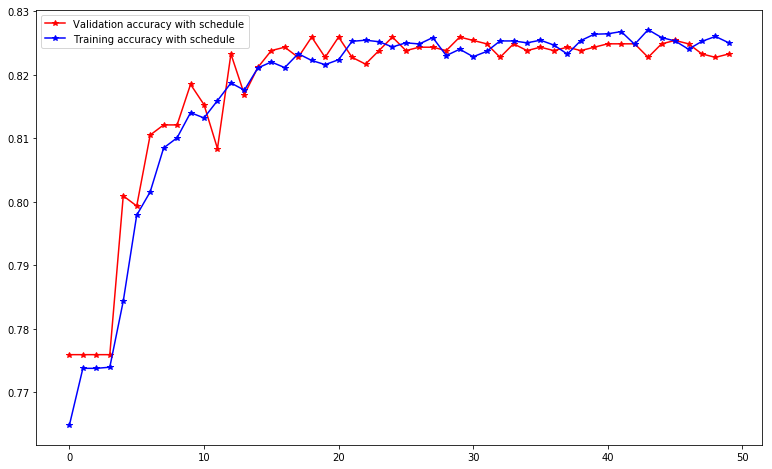

In [16]:
from matplotlib import pyplot as plt

plt.figure(figsize=(13,8))

plt.plot(hist_300.history["val_acc"],'r*-')
plt.plot(hist_300.history["acc"],'b*-')
plt.legend(("Validation accuracy with schedule","Training accuracy with schedule"))


plt.show()    

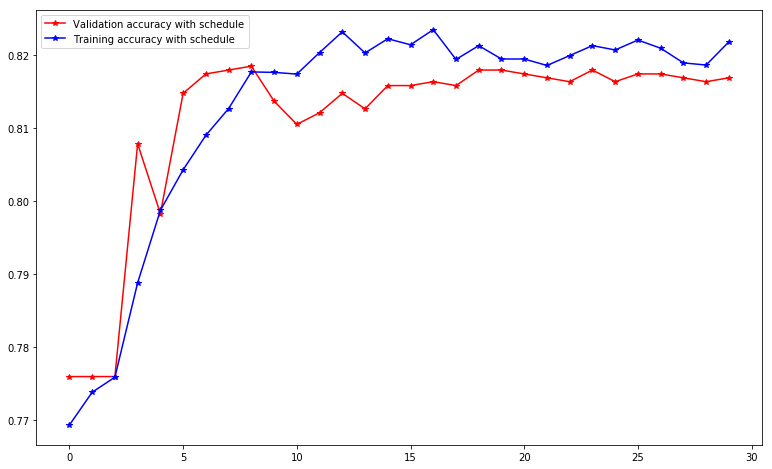

In [17]:
from matplotlib import pyplot as plt

plt.figure(figsize=(13,8))

plt.plot(hist_300_4.history["val_acc"],'r*-')
plt.plot(hist_300_4.history["acc"],'b*-')
plt.legend(("Validation accuracy with schedule","Training accuracy with schedule"))
plt.savefig("documents/Acc_google_new")
plt.show()    

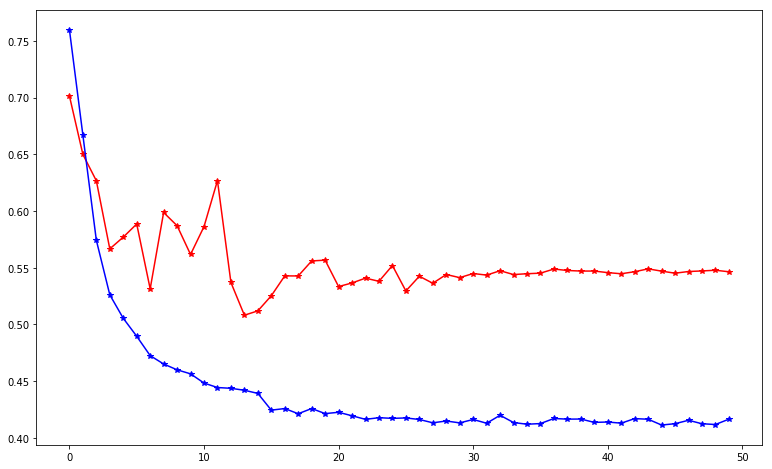

In [18]:
from matplotlib import pyplot as plt

plt.figure(figsize=(13,8))
plt.plot(hist_300.history["val_loss"],'r*-')
plt.plot(hist_300.history["loss"],'b*-')
plt.show()    

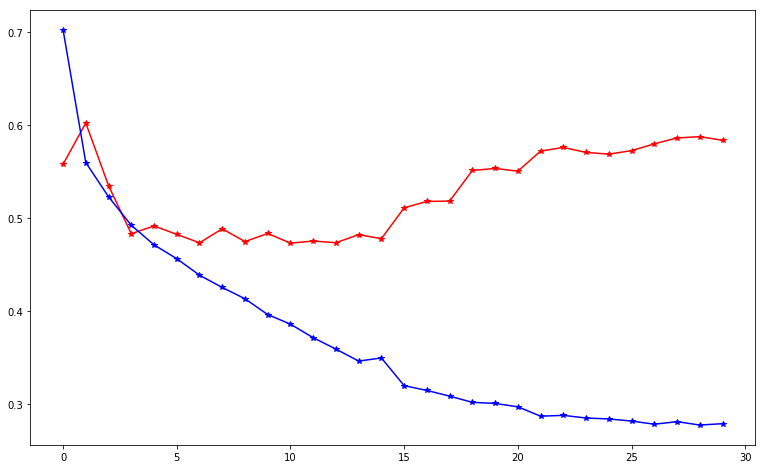

In [24]:
from matplotlib import pyplot as plt

plt.figure(figsize=(13,8))
plt.plot(hist_300_4.history["val_loss"],'r*-')
plt.plot(hist_300_4.history["loss"],'b*-')

plt.show()    

In [17]:
np.save("variables/review_rating/acc_300.npy",acc_300)
np.save("variables/review_rating/acc_google.npy",acc_google)

In [19]:
acc_300 = np.load("variables/review_rating/acc_300.npy")
acc_google = np.load("variables/review_rating/acc_google.npy")

# Training of the model on all the data

In [106]:
Final = model_creation()
Final.fit(np.array(sentences_v),to_categorical(y),epochs=40,batch_size=100)

/home/robin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(64, kernel_size=10, activation="relu", input_shape=(50, 300), padding="same")`
  app.launch_new_instance()


Epoch 1/40
  200/10086 [..............................] - ETA: 1:34:44 - loss: 0.6930 - acc: 0.5000

/home/robin/.local/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.263359). Check your callbacks.
  % delta_t_median)


10086/10086 [==============================] - 128s 13ms/step - loss: 0.6533 - acc: 0.5952
Epoch 2/40
10086/10086 [==============================] - 9s 879us/step - loss: 0.3720 - acc: 0.8548
Epoch 3/40
10086/10086 [==============================] - 9s 871us/step - loss: 0.2951 - acc: 0.8866
Epoch 4/40
10086/10086 [==============================] - 9s 875us/step - loss: 0.2659 - acc: 0.8910
Epoch 5/40
10086/10086 [==============================] - 9s 872us/step - loss: 0.2439 - acc: 0.8999
Epoch 6/40
10086/10086 [==============================] - 9s 876us/step - loss: 0.2407 - acc: 0.9029
Epoch 7/40
10086/10086 [==============================] - 9s 886us/step - loss: 0.2256 - acc: 0.9058
Epoch 8/40
10086/10086 [==============================] - 9s 873us/step - loss: 0.2178 - acc: 0.9121
Epoch 9/40
10086/10086 [==============================] - 9s 874us/step - loss: 0.2190 - acc: 0.9104
Epoch 10/40
10086/10086 [==============================] - 9s 876us/step - loss: 0.1995 - acc: 0.9118

# Cross validation and model comparaison

In [14]:
def time_estimation_cross_val(nb_epochs,nb_s_epoch,nb_split):
    nb_min = (nb_epochs*nb_s_epoch*nb_split*nb_split)/60
    print("The cross_validation will take around : "+str(nb_min)+" mn")
    return nb_min
    
def cross_val(model_function,x_train,y_train,nb_splits,nb_epochs):
    """ This function allows to do a cross validation over a keras model
        Keyword arguments:
        model_function -- A function returning your model
        x_train -- The train data
        y_train -- The train target
        nb_splits -- The number of folds 
        nb_epochs -- The number of epochs you want to train your network with 
                     /!\ One validation will be a total of nb_folds*nb_epochs total number of epochs
    """
    import time    
    start_time = time.time()
    
    indices = np.linspace(0,len(x_train)-1,num=nb_splits+1,dtype=int)
    split_data = []

    # Creation of the splits
    split_data.append((x_train[indices[0]:indices[1]],y_train[indices[0]:indices[1]]))
    for i in range(1,len(indices)-1):
        split_data.append((x_train[indices[i]+1:indices[i+1]],y_train[indices[i]+1:indices[i+1]]))

    # Cross val    
    score = []
    for i in range(nb_splits):
        model = model_function()
        valid = split_data[i]
        for j in range(nb_splits):
            if (j != i):
                model.fit(split_data[j][0],split_data[j][1],epochs=nb_epochs,batch_size=150)
        score.append(model.evaluate(valid[0],valid[1]))
        
    std = np.std([a[1] for a in score])
    mean = np.mean([a[1] for a in score])
    
    print("Accruracy neural network: "+str(mean*100)+"% +- "+str(std*100)+"%")
    print("--- %s minutes elapsed---" % ((time.time() - start_time)/60))

    return model,score,(mean,std)


def multi_cross_val(model_functions,x_train,y_train,nb_splits,nb_epochs):
    """ This function allows to compare different models over a k-fold cross validation
        Keyword arguments:
        model_functions -- A list containing the functions returning the different models you want to test
        x_train -- The train data
        y_train -- The train target
        nb_splits -- The number of folds 
        nb_epochs -- The number of epochs you want to train your network with 
                     /!\ One validation will be a total of nb_folds*nb_epochs total number of epochs
    """
    import time
    
    start_time = time.time()
    
    indices = np.linspace(0,len(x_train)-1,num=nb_splits+1,dtype=int)
    split_data = []

    # Creeation of the splits
    split_data.append((x_train[indices[0]:indices[1]],y_train[indices[0]:indices[1]]))
    for i in range(1,len(indices)-1):
        split_data.append((x_train[indices[i]+1:indices[i+1]],y_train[indices[i]+1:indices[i+1]]))

    # Cross val    
    score = []
    for i in range(nb_splits):
        print("Split no :"+str(i))
        models = [f() for f in model_functions]
        valid = split_data[i]
        for j in range(nb_splits):
            if (j != i):
                for m in models :
                    try : 
                        m.fit(split_data[j][0],split_data[j][1],epochs=nb_epochs,batch_size=150)
                    except :
                        print(m.summary())
        for k in range(len(models)) :
            score.append((k,models[k].evaluate(valid[0],valid[1])))
    std = {}
    mean = {}
    
    for i in range(len(models)):
        tmp = [s for s in score if s[0]==i]
        std[i]=np.std([a[1][1] for a in tmp])
        mean[i]=np.mean([a[1][1] for a in tmp])

    for k in mean.keys():
        print("Accruracy neural network"+str(k) +" : "+str(mean[k]*100)+"% +- "+str(std[k]*100)+"%")
    
    print("--- %s minutes elapsed---" % ((time.time() - start_time)/60))

    return models,score,mean,std

In [77]:
NN,score, printing = cross_val(model_creation,x_vec_train,y_vec_train,3,50)

/home/robin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(64, kernel_size=10, activation="relu", input_shape=(50, 300), padding="same")`
  app.launch_new_instance()


Epoch 1/50
2688/2688 [==============================] - 5s 2ms/step - loss: 0.6923 - acc: 0.5219
Epoch 2/50
2688/2688 [==============================] - 2s 819us/step - loss: 0.6904 - acc: 0.5417
Epoch 3/50
2688/2688 [==============================] - 2s 819us/step - loss: 0.6442 - acc: 0.6261
Epoch 4/50
2688/2688 [==============================] - 2s 825us/step - loss: 0.4691 - acc: 0.7946
Epoch 5/50
2688/2688 [==============================] - 2s 846us/step - loss: 0.3898 - acc: 0.8497
Epoch 6/50
2688/2688 [==============================] - 2s 811us/step - loss: 0.3502 - acc: 0.8757
Epoch 7/50
2688/2688 [==============================] - 2s 829us/step - loss: 0.3177 - acc: 0.8776
Epoch 8/50
2688/2688 [==============================] - 2s 819us/step - loss: 0.3144 - acc: 0.8854
Epoch 9/50
2688/2688 [==============================] - 2s 821us/step - loss: 0.2777 - acc: 0.9003
Epoch 10/50
2688/2688 [==============================] - 2s 828us/step - loss: 0.2697 - acc: 0.8996
Epoch 11/50

In [26]:
NNs,score,mean,std = multi_cross_val(functions,x_vec_train,y_vec_train,3,40)

Split no :0


/home/robin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(64, kernel_size=10, activation="relu", input_shape=(50, 300), padding="causal")`
  app.launch_new_instance()
/home/robin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(32, kernel_size=5, activation="relu", input_shape=(50, 300), padding="causal")`


Epoch 1/40
2688/2688 [==============================] - 3s 1ms/step - loss: 0.6929 - acc: 0.5307
Epoch 2/40
2688/2688 [==============================] - 2s 621us/step - loss: 0.6875 - acc: 0.5409
Epoch 3/40
2688/2688 [==============================] - 2s 617us/step - loss: 0.6090 - acc: 0.5472
Epoch 4/40
2688/2688 [==============================] - 2s 623us/step - loss: 0.5290 - acc: 0.7210
Epoch 5/40
2688/2688 [==============================] - 2s 624us/step - loss: 0.4668 - acc: 0.7969
Epoch 6/40
2688/2688 [==============================] - 2s 627us/step - loss: 0.3914 - acc: 0.8337
Epoch 7/40
2688/2688 [==============================] - 2s 623us/step - loss: 0.3709 - acc: 0.8668
Epoch 8/40
2688/2688 [==============================] - 2s 622us/step - loss: 0.3287 - acc: 0.8832
Epoch 9/40
2688/2688 [==============================] - 2s 623us/step - loss: 0.3215 - acc: 0.8728
Epoch 10/40
2688/2688 [==============================] - 2s 626us/step - loss: 0.2893 - acc: 0.8903
Epoch 11/40

# Plotting of validation curve

In [ ]:
from matplotlib import pyplot as plt
acc = []
for i in range(len(hist)):
    acc.append(hist[i][1])

plt.plot(acc)    
plt.show()    


# Recuperation of the best model

In [ ]:
best = NN1

# Evaluation of the model on the test set

In [36]:
for nn in NNs :
    print(nn.evaluate(x_vec_test,y_vec_test))


2018/2018 [==============================] - 0s 144us/step
[0.3517975202778086, 0.9063429137760158]
2018/2018 [==============================] - 1s 399us/step
[0.5170062327195243, 0.8984142715559961]
2018/2018 [==============================] - 1s 485us/step
[0.5657669939263997, 0.8904856293359762]
2018/2018 [==============================] - 1s 550us/step
[0.5271913464075783, 0.8909811694747275]
2018/2018 [==============================] - 1s 317us/step
[0.36106528522184367, 0.8954410307234886]


# Saving of the model

In [14]:
def save_model(model,name,path):
    model_json = model.to_json()
    with open(path+name+".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
        model.save_weights(path+name+".h5")
        print("Saved model to disk")
        
def load_model(name,path):
    from keras.models import model_from_json
    # load json and create model
    json_file = open(path+name+'.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(path+name+".h5")
    print("Loaded model from disk")
    return loaded_model


In [15]:
save_model(NN,"Pre_training","models/review_rating")

Saved model to disk


In [17]:
NN = load_model("review_ratingPre_training","models/")
NN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Loaded model from disk


In [ ]:
NN_loaded = load_model("labelled+books_final","models/")
NN_loaded.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
NN_loaded.evaluate(x_vec_test,y_vec_test)

# Utilisation of the model for live prediction

In [107]:
def predict(sentence,word2Vec_model,model,max_len=50):
    sentence = sentence.split(" ")
    good_sentence = []
    unusued_words = []
    for i in range(len(sentence)):
        try :
            sentence[i]=sentence[i].lower()
            good_sentence.append(word2Vec_model.wv[sentence[i]])
        except : 
            unusued_words.append(sentence[i])
    sentence_length = len(good_sentence)
    if(sentence_length<max_len):    
        for j in range(max_len-sentence_length):
            good_sentence.append([0]*300)

    good_sentence = np.array(good_sentence)        
    good_sentence = np.reshape(good_sentence, (1,good_sentence.shape[0], good_sentence.shape[1]))
    return model.predict(good_sentence)

In [108]:
def vote(score):
    import numpy as np
    neg=[]
    pos=[]
    for s in score :
        neg.append(s[0][0])
        pos.append(s[0][1])
    sup_neg = [n for n in neg if n > 0.5]
    sup_pos = [p for p in pos if p > 0.5]

    return [np.mean(neg),np.mean(pos)]
    
def predict(sentence,word2Vec_model,model,max_len=50,word_length=300):
    import numpy as np
    sentence = sentence.split(" ")
    good_sentence = []
    unusued_words = []
    for i in range(len(sentence)):
        try :
            sentence[i]=sentence[i].lower()
            good_sentence.append(word2Vec_model.wv[sentence[i]])
        except : 
            unusued_words.append(sentence[i])
    sentence_length = len(good_sentence)
    
    if(sentence_length<max_len):    
        for j in range(max_len-sentence_length):
            good_sentence.append([0]*word_length)     
            
    if (sentence_length > max_len) :
        predictions = []
        ind = 0
        for i in range(int(np.ceil(sentence_length/max_len))):
            sent_tmp = good_sentence[ind:ind+max_len]
            if(len(sent_tmp)<max_len):
                for j in range(max_len-len(sent_tmp)):
                    sent_tmp.append([0]*word_length)    
            sent_tmp = np.array(sent_tmp)        
            sent_tmp = np.reshape(sent_tmp, (1,sent_tmp.shape[0], sent_tmp.shape[1]))
            try :
                predictions.append(model.predict(sent_tmp))
                ind+=max_len                    
            except : 
                print("Erreur au découpage no :"+str(i))
        return vote(predictions)
    
    good_sentence = np.array(good_sentence)        
    good_sentence = np.reshape(good_sentence, (1,good_sentence.shape[0], good_sentence.shape[1]))
    return np.squeeze(model.predict(good_sentence))

In [109]:
best=Final
sentence =input()
print(" Négatif        Positif")
print(predict(sentence,model,best))

It was amazing
 Négatif        Positif


/home/robin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


[4.2402942e-04 9.9957591e-01]


# Data opening for test

### First dataset

In [ ]:
file  = open("Text/rt-polarity-neg.txt", "rt",encoding = "ISO-8859-1")

content = file.read()
contents=[]
x_pred=[]
y_pred=[]
contents=content.split("\n")
del contents[-1]
del contents[-1]

for i in range(len(contents)):
    x_pred.append(contents[i])
    y_pred.append(0)

file  = open("Text/rt-polarity-pos.txt", "rt",encoding = "ISO-8859-1")
content = file.read()
contents=[]
contents=content.split("\n")
del contents[-1]
del contents[-1]

for i in range(len(contents)):
    x_pred.append(contents[i])
    y_pred.append(1)    


In [110]:
def test(word2Vec_model,model):
    # This function take an already trained model return the accuracy of the model over an external dataset 
    y=[]
    y_pred=[]
    cnt = 1

    with open("datasets/rt-polarity-neg.txt","rt",encoding = "ISO-8859-1") as fp:
            line = fp.readline()
            while line:
                y.append(0)
                y_pred.append(predict(line,word2Vec_model,model))
                line = fp.readline()
                cnt += 1
                
    with open("datasets/rt-polarity-pos.txt","rt",encoding = "ISO-8859-1") as fp:
            line = fp.readline()
            while line:
                y.append(1)
                y_pred.append(predict(line,word2Vec_model,model))
                line = fp.readline()
                cnt += 1
                
    print(str(cnt)+" lignes testées")
    
    y_pred_trans=[]  
    
    for i in range(len(y_pred)):
        try : 
            if(y_pred[i][0]>y_pred[i][1]):
                y_pred_trans.append(0)
            else :
                y_pred_trans.append(1)
        except : 
            print("Bug ligne : "+str(i))
    from sklearn.metrics import confusion_matrix
    cf = confusion_matrix(y,y_pred_trans)
    acc = (cf[0][0]+cf[1][1])/(cf[0][0]+cf[1][1]+cf[0][1]+cf[1][0])
    print("Matrice de confusion : \n "+ str (cf))
    print("Accuracy : "+ str(acc))
    

In [111]:
test(model,Final)

/home/robin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


10663 lignes testées
Matrice de confusion : 
 [[3872 1459]
 [1563 3768]]
Accuracy : 0.7165634965297317


### Second dataset

In [112]:
import glob   
path = 'datasets/txt_sentoken/pos/*.txt'   
files=glob.glob(path)   
sentences_test = []
y_test = []
for file in files:
    f=open(file, 'r')  
    sentences_test.append(f.read())
    y_test.append(1)
    f.close()
    
path = 'datasets/txt_sentoken/neg/*.txt'   
files=glob.glob(path)
for file in files:
    f=open(file, 'r')  
    sentences_test.append(f.read())
    y_test.append(0)
    f.close()

In [114]:
y_pred = []
for s in sentences_test:
    y_pred.append(predict(s,model,Final))

/home/robin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


In [115]:
from sklearn.metrics import confusion_matrix
y_pred_trans=[]
i=0
for y_tmp in y_pred:
    i+=1
    if(y_tmp[0] > y_tmp[1]):
        y_pred_trans.append(0)
    else :
        y_pred_trans.append(1)
        
cf = confusion_matrix(y_test,y_pred_trans)
acc = (cf[0][0]+cf[1][1])/(cf[0][0]+cf[1][1]+cf[0][1]+cf[1][0])
print("Matrice de confusion : \n "+ str (cf))
print("Accuracy : "+ str(acc))

Matrice de confusion : 
 [[755 245]
 [274 726]]
Accuracy : 0.7405
